# Exploratory Data Analysis (EDA)

This notebook performs business-led exploratory analysis to:
- Understand demand seasonality and volatility
- Assess cancellation risk
- Analyze pricing (ADR) behavior
- Evaluate capacity utilization patterns

The goal is to justify forecasting, scenario analysis, and finance modeling.


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("cleaned_hotel_bookings.csv", parse_dates=['arrival_date','week_start'])


In [4]:
# Demand Seasonality Analysis
# weekly aggregation
weekly_demand = df.groupby(['week_start','hotel'])['net_booking'].sum().reset_index()

weekly_demand.head()

,week_start,hotel,net_booking
0,2015-06-29,City Hotel,85
1,2015-06-29,Resort Hotel,171
2,2015-07-06,City Hotel,61
3,2015-07-06,Resort Hotel,218
4,2015-07-13,City Hotel,123


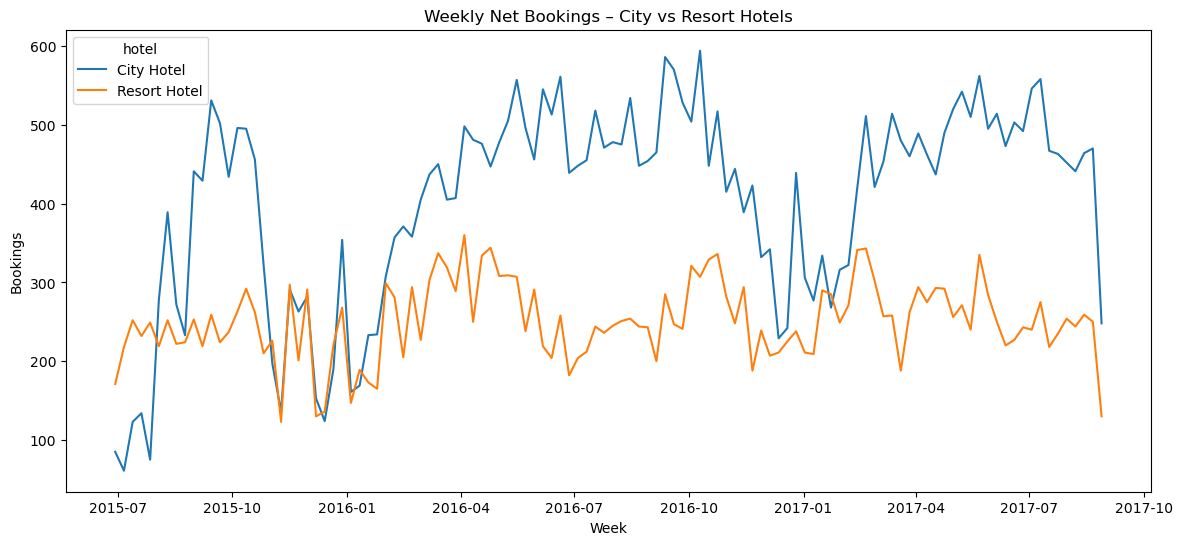

In [5]:
plt.figure(figsize=(14,6))
sns.lineplot(data=weekly_demand, x='week_start', y='net_booking', hue='hotel')
plt.title("Weekly Net Bookings – City vs Resort Hotels")
plt.xlabel("Week")
plt.ylabel("Bookings")
plt.show()

In [6]:
# Cancellation Rate Over Time
weekly_cancel = df.groupby('week_start').agg(
    gross_bookings=('gross_booking','sum'),
    net_bookings=('net_booking','sum')
).reset_index()

weekly_cancel['cancellation_rate'] = (1 - (weekly_cancel['net_bookings'] / weekly_cancel['gross_bookings']))*100

weekly_cancel.head()

,week_start,gross_bookings,net_bookings,cancellation_rate
0,2015-06-29,410,256,37.560976
1,2015-07-06,490,279,43.061224
2,2015-07-13,682,375,45.014663
3,2015-07-20,758,366,51.715040
4,2015-07-27,576,324,43.750000


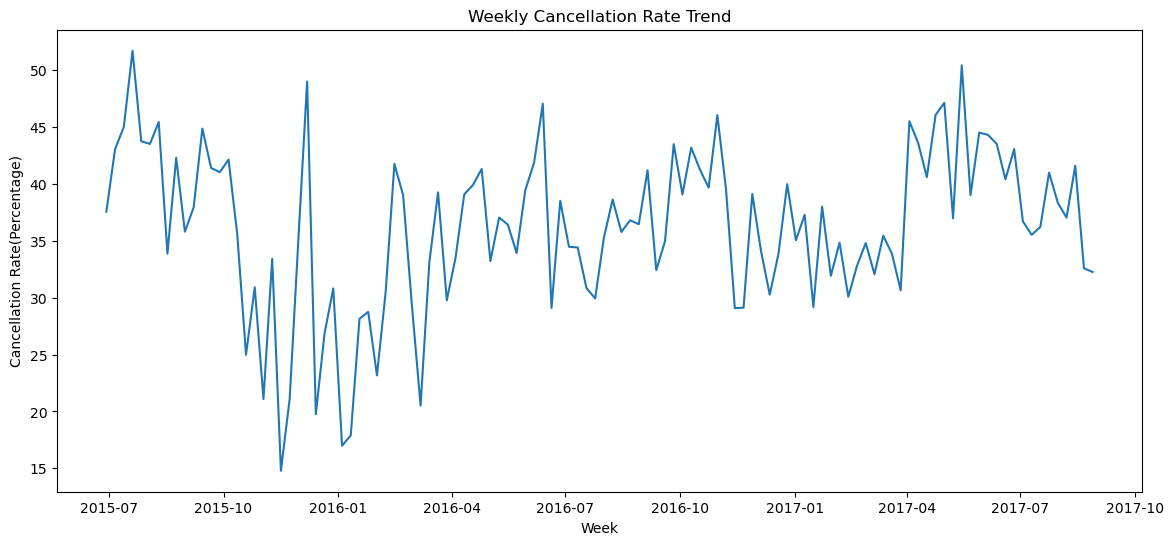

In [7]:
plt.figure(figsize=(14,6))
sns.lineplot(data=weekly_cancel, x='week_start', y='cancellation_rate')
plt.title("Weekly Cancellation Rate Trend")
plt.xlabel("Week")
plt.ylabel("Cancellation Rate(Percentage)")
plt.show()

In [8]:
# Cancellation rate by Hotel type

cancel_by_hotel = df.groupby('hotel').agg(
    gross=('gross_booking','sum'),
    net=('net_booking','sum')
).reset_index()

cancel_by_hotel['cancel_rate'] = (1 - cancel_by_hotel['net']/cancel_by_hotel['gross'])*100
cancel_by_hotel

,hotel,gross,net,cancel_rate
0,City Hotel,78999,45920,41.872682
1,Resort Hotel,39675,28565,28.002520


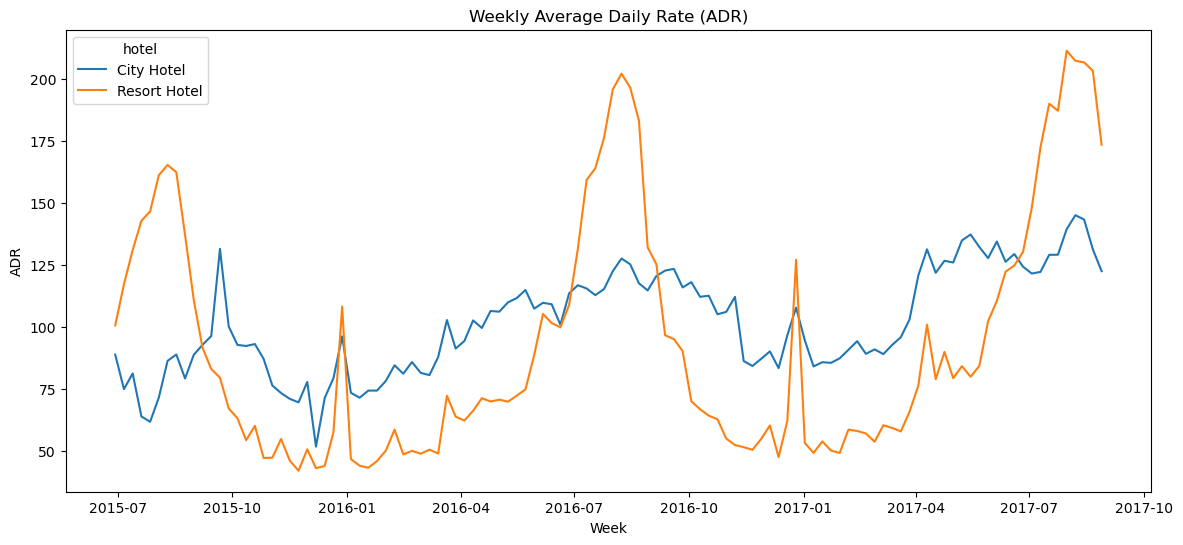

In [9]:
#Average Daily Rate (ADR) trend over time
weekly_adr = df[df['is_canceled']==0].groupby(['week_start','hotel'])['adr'].mean().reset_index()

plt.figure(figsize=(14,6))
sns.lineplot(data=weekly_adr, x='week_start', y='adr', hue='hotel')
plt.title("Weekly Average Daily Rate (ADR)")
plt.xlabel("Week")
plt.ylabel("ADR")
plt.show()

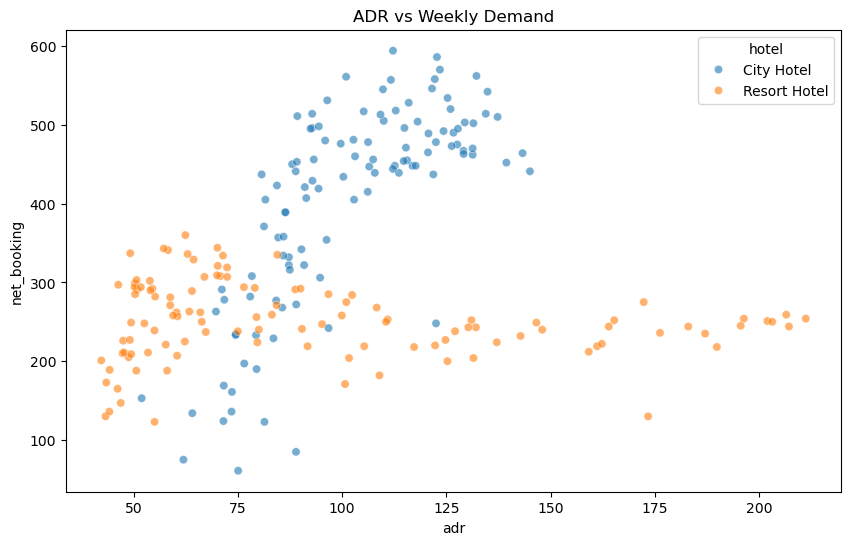

In [10]:
merged = pd.merge(weekly_demand, weekly_adr, on=['week_start','hotel'])

plt.figure(figsize=(10,6))
sns.scatterplot(data=merged, x='adr', y='net_booking', hue='hotel', alpha=0.6)
plt.title("ADR vs Weekly Demand")
plt.show()

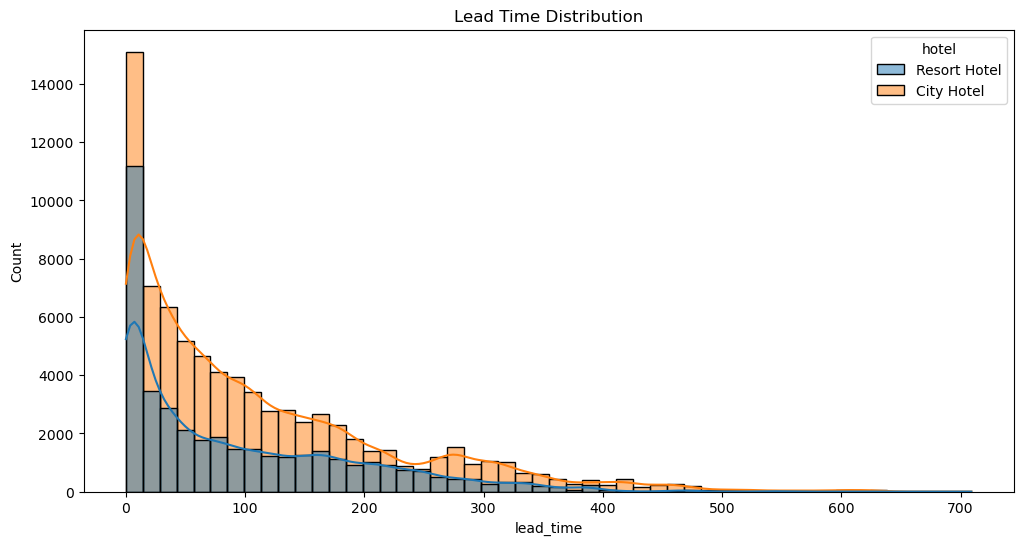

In [11]:
# Lead Time Analysis
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='lead_time', hue='hotel', bins=50, kde=True)
plt.title("Lead Time Distribution")
plt.show()

Lead-time distributions are heavily right-skewed for both hotel segments, indicating that most bookings occur close to the arrival date, with a small but uncertain share booked far in advance. City Hotels exhibit longer and more dispersed lead times, reflecting corporate and group travel that improves forecast visibility but increases cancellation exposure. Resort Hotels show shorter lead times and stronger seasonality, making demand more sensitive to timing and pricing. These patterns reinforce the use of net bookings for planning, conservative demand anchoring for City Hotels, and seasonal forecasting for Resort Hotels.

In [12]:
cancel_vs_lead = (
    df.groupby(pd.cut(df['lead_time'], bins=[0, 7, 30, 90, 180, 365]))
      .agg(cancel_rate_pct=('is_canceled', lambda x: x.mean() * 100))
)

cancel_vs_lead

C:\Users\arvin\AppData\Local\Temp\ipykernel_26696\1783628207.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df['lead_time'], bins=[0, 7, 30, 90, 180, 365]))


,cancel_rate_pct
lead_time,
"(0, 7]",11.045766
"(7, 30]",27.975402
"(30, 90]",37.805085
"(90, 180]",44.765548
"(180, 365]",55.528701


In [13]:
# Diagnostic country mix 
top_countries = df['country'].value_counts().head(5).index.tolist()

df['country_bucket'] = np.where(df['country'].isin(top_countries), df['country'], 'Rest of World')

country_demand = df.groupby('country_bucket')['net_booking'].sum().sort_values(ascending=False)

country_demand


country_bucket
Rest of World    23434
PRT              20491
GBR               9650
FRA               8467
ESP               6375
DEU               6068
Name: net_booking, dtype: int64

**CAPACITY ASSUMPTIONS:**

-Capacity was proxied using observed peak weekly room-night demand from EDA.
-City Hotel capacity was set to 3,500 room nights per week (~500 rooms), reflecting higher volume and greater cancellation volatility. 
-Resort Hotel capacity was set to 2,500 room nights per week (~350 rooms), reflecting lower but more stable seasonal demand. These assumptions anchor utilization analysis to observed operating scale rather than arbitrary room counts.

In [1]:
# Capacity Assumptions
CITY_CAPACITY = 500 * 7
RESORT_CAPACITY = 350 * 7

In [14]:
# Occupancy Computation
weekly_room_nights = df.groupby(['week_start','hotel'])['total_stay_nights'].sum().reset_index()

weekly_room_nights['capacity'] = weekly_room_nights['hotel'].map({
    'City Hotel': CITY_CAPACITY,
    'Resort Hotel': RESORT_CAPACITY
})

weekly_room_nights['occupancy'] = weekly_room_nights['total_stay_nights'] / weekly_room_nights['capacity']

weekly_room_nights.head()

,week_start,hotel,total_stay_nights,capacity,occupancy
0,2015-06-29,City Hotel,525,3500,0.150000
1,2015-06-29,Resort Hotel,1216,2450,0.496327
2,2015-07-06,City Hotel,710,3500,0.202857
3,2015-07-06,Resort Hotel,1448,2450,0.591020
4,2015-07-13,City Hotel,952,3500,0.272000


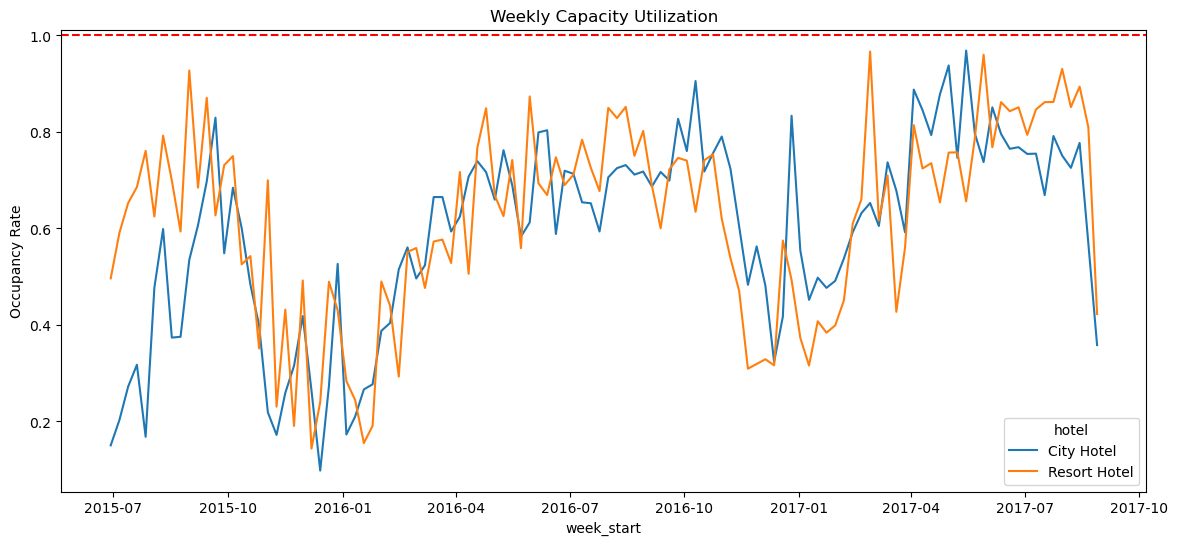

In [15]:
plt.figure(figsize=(14,6))
sns.lineplot(data=weekly_room_nights, x='week_start', y='occupancy', hue='hotel')
plt.axhline(1, linestyle='--', color='red')
plt.title("Weekly Capacity Utilization")
plt.ylabel("Occupancy Rate")
plt.show()

In [ ]:
## Key Business Insights from EDA

1. Demand patterns differ structurally by segment: Resort Hotels exhibit strong and stable seasonality, while City Hotels show higher volatility and structural shifts, necessitating segment-specific forecasting approaches.
2. High and variable cancellation rates—particularly for City Hotels—introduce material demand uncertainty, making net bookings and realized room nights more appropriate planning metrics than gross bookings.
3. Average Daily Rate (ADR) demonstrates pronounced seasonal movement, especially for Resort Hotels, indicating revenue volatility driven jointly by price and demand rather than volume alone.
4. Lead time distributions reveal a trade-off between forecast visibility and cancellation exposure, with longer lead times increasing planning horizon but also elevating cancellation risk.
5. Capacity utilization analysis shows prolonged periods of under-utilization interspersed with peak stress weeks approaching full capacity, highlighting the need for demand forecasting and scenario-based capacity planning rather than static capacity assumptions.

Collectively, these insights motivate the use of segmented demand forecasting, scenario analysis, and financial modeling to support revenue, utilization, and margin optimization for travel platform decision-making.